In [1]:
import torchvision.transforms as transforms
import cv2
import numpy as np
import torchvision
import torch
from PIL import Image

from torchvision import models
from torch.hub import load_state_dict_from_url

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', #'watermelon', 'tree'
]

In [3]:
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
def predict(image, model, device, detection_threshold):
    
    image = transform(image).to(device)
    image = image.unsqueeze(0) 
    outputs = model(image) 
    
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
   
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    
    return boxes, pred_classes, outputs[0]['labels']

In [6]:
def draw_boxes(boxes, classes, labels, image):
    
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, 
                                                    min_size=1024)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
import os
paths = os.listdir("/content/inputs")

print(paths)

['v7w_107927.jpg', 'v7w_150327.jpg', 'v7w_150304.jpg', 'v7w_49.jpg', 'v7w_47.jpg', 'v7w_48.jpg', 'v7w_107931.jpg', 'v7w_61534.jpg', 'v7w_107964.jpg', 'v7w_107916.jpg', 'v7w_61535.jpg', 'v7w_150365.jpg', 'v7w_61579.jpg', 'v7w_150296.jpg', 'v7w_150275.jpg', 'v7w_61528.jpg', 'v7w_150324.jpg', 'v7w_150325.jpg', 'v7w_107978.jpg', 'v7w_107965.jpg', 'v7w_107910.jpg', 'v7w_150330.jpg', 'v7w_150345.jpg', 'v7w_150295.jpg', 'v7w_107912.jpg', 'v7w_150351.jpg', 'v7w_150329.jpg', 'v7w_150336.jpg', 'v7w_46.jpg', 'v7w_276.jpg', 'v7w_107939.jpg', 'v7w_61587.jpg', 'v7w_107947.jpg', 'v7w_107997.jpg', 'v7w_107901.jpg', 'v7w_150370.jpg', 'v7w_150362.jpg', 'v7w_150258.jpg', 'v7w_41.jpg', 'v7w_150367.jpg', 'v7w_61524.jpg', 'v7w_107932.jpg', 'v7w_150356.jpg', 'v7w_42.jpg', 'v7w_61544.jpg', 'v7w_107941.jpg', 'v7w_107907.jpg', 'v7w_150368.jpg', 'v7w_61593.jpg', 'v7w_107977.jpg', 'v7w_150282.jpg', 'v7w_150326.jpg', 'v7w_61526.jpg', 'v7w_150332.jpg', 'v7w_44.jpg', 'v7w_107994.jpg', 'v7w_61543.jpg', 'v7w_61603.jpg

In [10]:
def crop_detections(image, boxes, pred_labels, labels, count):
  image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
  for i, box in enumerate(boxes):
    xmin, ymin, xmax, ymax = box
    cropped_img = image[int(ymin):int(ymax), int(xmin):int(xmax)]
    cv2.imwrite(f"/content/drive/MyDrive/11777/crop/{count}_{i}.jpg", cropped_img)

  labels.extend(pred_labels)


In [12]:
from google.colab.patches import cv2_imshow

#Run inference
class_labels = []
count = 0
for path in paths:
  image = Image.open(f"/content/inputs/{path}")
  image_array = np.array(image)
  model.eval().to(device)
  boxes, classes, labels = predict(image, model, device, 0.8)
  crop_detections(image_array, boxes, classes, class_labels, count)
  image = draw_boxes(boxes, classes, labels, image)
  #cv2_imshow(image)
  cv2.imwrite(f"/content/drive/MyDrive/11777/outputs/{count}.jpg", image)
  count += 1

In [32]:
class ResNet101(models.ResNet):
    def __init__(self, num_classes=1000, pretrained=True, **kwargs):
        super().__init__(block=models.resnet.Bottleneck, layers=[3, 4, 23, 3], num_classes=num_classes, **kwargs)
        if pretrained:
            state_dict = load_state_dict_from_url(models.resnet.model_urls['resnet101'], progress=True)
            self.load_state_dict(state_dict)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

In [59]:
class v7W_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, num_images=1000):

        self.data = []

        images = os.listdir(data_path)
        label = class_labels

        current_data = [(os.path.join("/content/drive/MyDrive/11777/crop", images[i]), label[i]) for i in range(len(images))]
        self.data += current_data

        num_images = len(self.data)

        # https://pytorch.org/hub/pytorch_vision_resnet/.
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        image_path, label = self.data[index]

        image = Image.open(image_path)

        try:
            image = self.transform(image)
        except Exception:
            return None

        dict_data = {
            'image' : image,
            'label' : label,
            'image_path' : image_path
        }
        return dict_data


In [60]:
def get_features(dataset, batch, num_images):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = ResNet101(pretrained=True)
    model.eval()
    model.to(device)

    dataset = v7W_Dataset(dataset, num_images)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)

    features = None
    labels = []

    for img_crop in dataloader:
        images = img_crop['image'].to(device)
        labels += img_crop['label']
        
        with torch.no_grad():
            output = model.forward(images)

        current_features = output.cpu().numpy()
        if features is not None:
            features = np.concatenate((features, current_features))
        else:
            features = current_features

    return features, labels

In [61]:
features, labels = get_features(
        dataset="/content/drive/MyDrive/11777/crop",
        batch=64,
        num_images=len(class_labels)
    )

tsne = TSNE(n_components=2).fit_transform(features)

In [62]:
n_colors = list(set(labels))

df = pd.DataFrame(labels, columns=['y'])
df['tsne1'] = tsne[:, 0]
df['tsne2'] = tsne[:, 1]

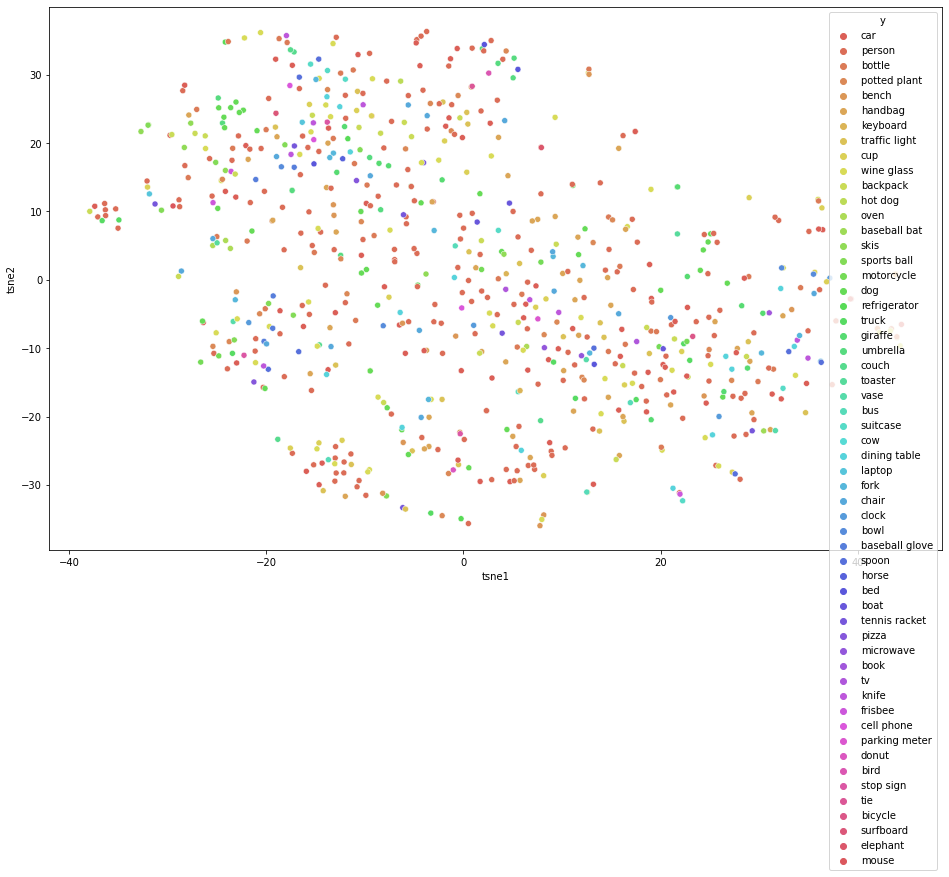

In [65]:
plt.figure(figsize=(16,10))
sns_plot = sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="y",
    palette=sns.color_palette("hls", len(n_colors)),
    data=df,
    legend="full"
)